In [13]:
!pip install -q kaggle

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bayusulistiyawan","key":"ac683652beff2450b83ea3404d402ca1"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [16]:
!kaggle datasets download -d hgultekin/bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 60.7MB/s]


In [17]:
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


In [18]:
import pandas as pd
import numpy as np
import string
import nltk
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
df.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [20]:
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [21]:
df.shape

(2225, 4)

In [22]:
df.isnull().any()

category    False
filename    False
title       False
content     False
dtype: bool

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [24]:
df = df[['category','title', 'content']]

In [25]:
df

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [26]:
#Cleansing Data
# lower-case all characters
df.title = df.title.apply(lambda x: x.lower())
df.content = df.content.apply(lambda x: x.lower())

# removing functuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df.title = df.title.apply(lambda x: cleaner(x))
    df.content = df.content.apply(lambda x: lem(x))

## lematization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df.title = df.title.apply(lambda x: lem(x))
    df.content = df.content.apply(lambda x: lem(x))

# removing number
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df['title'].apply(rem_numbers)
    df['content'].apply(rem_numbers)

# removing stopword
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df.title = df.title.apply(lambda x: stopword(x))
    df.content = df.content.apply(lambda x: lem(x))

In [27]:
# data category one-hot-encoding
category = pd.get_dummies(df.category)
df_cat = pd.concat([df, category], axis=1)
df_cat = df_cat.drop(columns='category')
df_cat.head(10)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,1,0,0,0,0
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,1,0,0,0,0
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,1,0,0,0,0
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,1,0,0,0,0
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,1,0,0,0,0
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,1,0,0,0,0
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,1,0,0,0,0
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",1,0,0,0,0
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,1,0,0,0,0
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,1,0,0,0,0


In [28]:
news = df_cat['title'].values + '' + df_cat['content'].values
label = df_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [29]:
# Split data into training and validation
from sklearn.model_selection import train_test_split
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [30]:
# tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train) 
tokenizer.fit_on_texts(news_test)
 
sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [31]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [32]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [33]:
# model fit
history = model.fit(padded_train, label_train, epochs=50, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
56/56 - 45s - loss: 1.5853 - accuracy: 0.2691 - val_loss: 1.5525 - val_accuracy: 0.3820
Epoch 2/50
56/56 - 38s - loss: 1.3548 - accuracy: 0.4101 - val_loss: 1.2940 - val_accuracy: 0.4472
Epoch 3/50
56/56 - 37s - loss: 0.9711 - accuracy: 0.5360 - val_loss: 0.9970 - val_accuracy: 0.6045
Epoch 4/50
56/56 - 38s - loss: 0.6864 - accuracy: 0.7298 - val_loss: 0.8030 - val_accuracy: 0.6921
Epoch 5/50
56/56 - 37s - loss: 0.4355 - accuracy: 0.8466 - val_loss: 0.7506 - val_accuracy: 0.7843
Epoch 6/50
56/56 - 37s - loss: 0.1322 - accuracy: 0.9629 - val_loss: 0.6232 - val_accuracy: 0.8427
Epoch 7/50
56/56 - 37s - loss: 0.0784 - accuracy: 0.9792 - val_loss: 0.7209 - val_accuracy: 0.7753
Epoch 8/50
56/56 - 37s - loss: 0.0917 - accuracy: 0.9792 - val_loss: 0.6337 - val_accuracy: 0.8000
Epoch 9/50
56/56 - 37s - loss: 0.0702 - accuracy: 0.9854 - val_loss: 0.6817 - val_accuracy: 0.8382
Epoch 10/50
56/56 - 37s - loss: 0.0590 - accuracy: 0.9820 - val_loss: 0.7322 - val_accuracy: 0.8382
Epoch 11/

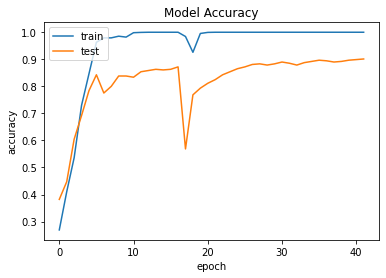

In [35]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

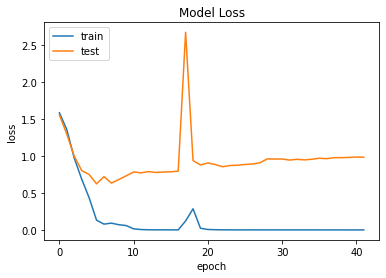

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()